# Trabajo Práctico 2 : Críticas cinematográficas N4

# Grupo: GPWin - N° 16

Integrantes:

- DIEM, Walter Gabriel

- MAIOLO, Alejandro

## Resumen

En esta notebook exploramos el uso de un modelo Naives Bayes con optimización de hiperparámetros del modelo y el vectorizer (count vectorizer más tfidf transformer). Además, tomamos como un hiperparámetro más de la optimización a la elección entre algunos stemmers y un lemmatizador, probando así la efectividad de los mismos para esta arquitectura.

## Preprocesamiento

Preparación de librerías

In [1]:
#%pip install joblib nltk

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import optuna

import spacy
import nltk

from nltk.stem import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Descargamos stopwords para NLTK

In [3]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Descargamos punkt de NLTK para obtener el word_tokenizer compatible con NLTK para poder hacer stemming luego (hace splits en palabras, 1 palabra = 1 token)

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Importamos las stopwords

In [5]:
from nltk.corpus import stopwords

Exploramos las stopwords en inglés y español

In [6]:
print(stopwords.words("english"))
print(len(stopwords.words("english")))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [7]:
print(stopwords.words("spanish"))
print(len(stopwords.words("spanish")))

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

Seteo de semillas para mejor reproducción de resultados

In [8]:
np.random.seed(1)
tf.random.set_seed(1)

Cargamos spacy con el linguistic knowledge en español

In [9]:
#spacy.prefer_gpu()
spacySpanish = spacy.load("es_core_news_sm")

### Prepocesamiento de datos

Exploramos el dataset de train y test

In [10]:
critics = pd.read_csv("./datasets/train.csv")
critics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [11]:
criticsTest = pd.read_csv("./datasets/test.csv")
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Tenemos 50k críticas para train y 8.6k entradas para test en Kaggle. Imprimimos una muestra para ver cómo son.

In [12]:
for critic in critics.sample(20)["review_es"]:
    print("###---###")
    print(critic)

###---###
Sin héroes muertos, se obtienen líneas estúpidas como esa, ya que se debe ver esta película de acción lamentablemente abismal. William Sanders es salvada por su amigo Harry Cotter durante una extracción en Vietnam, pero el enemigo capturado por el enemigo. Avance rápido de diez años y Harry ahora es un operario ruso en lavado de cerebro con un microchip de control mental implantado en su cerebro. Su nuevo Superior Ruso es Ivan jugó a la empuñadura obscena por Nick Nicholson, quien podría agregar no solo no intenta hablar con un acento ruso, sino que se parece a más un asistente de gasolina en Kentucky con sus dientes manchados. Lo que es aún más absurdo es el hecho de que también fue el entrenador de diálogo para esta película. Pronto William es re-reclutado por la CIA para cazar a Harry. Se adapta a Barbara, un luchador por la libertad que ha infiltrado el campamento de El Salvador de Ivan y pronto los dos están soplando la mitad de América del Sur. Algunas escenas son tan h

Cambiamos el nombre de la columna `review_es` a sólo `review`

In [13]:
critics.rename(columns={"review_es": "review"}, inplace=True)
critics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review       50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Revisamos valores nulos

In [14]:
criticsNull = critics.isnull().any()
criticsNull

ID             False
review         False
sentimiento    False
dtype: bool

No hay valores nulos en el dataset. Revisamos el balance entre reviews negativas y positivas 

In [15]:
critics["sentimiento"].value_counts()

positivo    25000
negativo    25000
Name: sentimiento, dtype: int64

Hay la misma cantidad de reviews positivas y negativas

Hacemos una función que a cada review le pasará a minúscula las palabras que no estén completamente escritas es mayúsculas

In [16]:
def toLowercaseIfNotFullyUppercase(review):
    words = review.split()
    parsedReview = []

    for word in words:
        if word.isupper():
            parsedReview.append(word)
        else:
            parsedReview.append(word.lower())

    return ' '.join(parsedReview)

In [17]:
critics["review"].apply(toLowercaseIfNotFullyUppercase)

0        uno de los otros críticos ha mencionado que de...
1        una pequeña pequeña producción.la técnica de f...
2        pensé que esta era una manera maravillosa de p...
3        básicamente, hay una familia donde un niño peq...
4        el "amor en el tiempo" de petter mattei es una...
                               ...                        
49995    pensé que esta película hizo un buen trabajo a...
49996    mala parcela, mal diálogo, mala actuación, dir...
49997    soy católica enseñada en escuelas primarias pa...
49998    voy a tener que estar en desacuerdo con el com...
49999    nadie espera que las películas de star trek se...
Name: review, Length: 50000, dtype: object

Encodeamos con LabelEncoder a los sentimientos

In [18]:
labelEncoder = LabelEncoder()
labelEncoder.fit(critics["sentimiento"])

print("Encoding queda:")
print(f"0 = {labelEncoder.inverse_transform([0])[0]}\n1 = {labelEncoder.inverse_transform([1])[0]}")

Encoding queda:
0 = negativo
1 = positivo


In [19]:
critics["sentimiento"] = labelEncoder.transform(critics["sentimiento"])
critics["sentimiento"].sample(4)

45997    0
9976     1
48042    0
3714     0
Name: sentimiento, dtype: int32

Creamos una función que remueva caracteres que no sean una palabra con espacios y los cambiamos por un espacio

In [20]:
def removePunctuation(review):
    return re.sub(r'[^\w\s]', ' ', review)

In [21]:
critics["review"] = critics["review"].apply(removePunctuation)
critics["review"].sample(10)

20895    El único bien  ya sea de los problemas  las pe...
35913    Si bien esto está horriblemente anticuado  deb...
29522    Mark Frechette Estrella como Mark  una univers...
8761     Si es cierto que el sadomasoquismo es una mone...
49943     SIR  ha jugado a LEAR más de 200 veces  pero ...
851      Steven Seagal s films of late have not exactly...
31578     Paso  Hanna Barbera de los años 60 y 70   Qué...
33833    Desde los primeros 10 segundos de tono de negr...
22722    Esta es la peor película absoluta que he visto...
23456    Después de haber visto al cazador de ciervos  ...
Name: review, dtype: object

In [22]:
def removeDigits(review):
    return re.sub('\d+', '', review)

In [23]:
critics["review"] = critics["review"].apply(removeDigits)
critics["review"].sample(10)

44898    Wow  acabo de presenciarme una de las mayores ...
4099     Esto es sin duda la peor película que he visto...
18059    Esta película no debe clasificarse como cine A...
37702    Como un matriz de béisbol  esta película no co...
47837    Esta fue una película de terror decepcionante ...
43446    Bueno     me gusta esta película en primer lug...
1862     De acuerdo  así que hay una vista frontal de u...
42590    El incidente de Salena es  con mucho  el direc...
3953     Veamos   Cuáles son las ventajas de ver Piranh...
11137    Pink Flamingos is a movie no word can explain ...
Name: review, dtype: object

Creamos una función para remover espacios múltiples y que haya un sólo espacio

In [24]:
def replaceMultipleSpaces(review):
    return re.sub(r'\s+', ' ', review).strip()

Creamos una función para aplicar stemming con NLTK de 3 tipos: Porter, Snowball (Porter2) y Lancaster

In [25]:
def applyStemming(review, stemmer):
    # No stemming
    if stemmer == None:
        return review

    wordsSplit = word_tokenize(review, language='spanish')

    if stemmer == "snowball":
        stemmer = SnowballStemmer('spanish')
    elif stemmer == "lancaster":
        stemmer = LancasterStemmer()
    else:
        stemmer = PorterStemmer()

    stemmedWordsSplit = map(lambda word: stemmer.stem(word), wordsSplit)
    stemmedReview = ' '.join(stemmedWordsSplit)
    stemmedReview = replaceMultipleSpaces(stemmedReview)
    return stemmedReview

Un ejemplo sin stemming

In [26]:
applyStemming(critics["review"][2], None)

'Pensé que esta era una manera maravillosa de pasar tiempo en un fin de semana de verano demasiado caliente  sentado en el teatro con aire acondicionado y observando una comedia alegre La parcela es simplista  pero el diálogo es ingenioso y los personajes son agradables  incluso el asesino en serie de la sospecha de pan del pozo  Mientras que algunos pueden decepcionarse cuando se dan cuenta de que este no es el punto de partido   la adicción al riesgo  pensé que era una prueba de que Woody Allen todavía está en control del estilo que muchos de nosotros hemos crecido a amar  Esto fue el más reído En una de las comedias de Woody en años   Dare  digo una década   Mientras nunca me quedé impresionado con Scarlet Johanson  en esto logró tonificar su imagen  sexy  y saltó a una joven promedio  pero enérgica  Esto puede que no sea la joya de la corona de su carrera  pero fue Wittier  El diablo viste prada  y más interesante que  Superman  una gran comedia para ir a ver con amigos '

Con stemming Porter

In [27]:
applyStemming(critics["review"][2], "porter")

'pensé que esta era una manera maravillosa de pasar tiempo en un fin de semana de verano demasiado calient sentado en el teatro con air acondicionado y observando una comedia alegr la parcela es simplista pero el diálogo es ingenioso y lo personaj son agrad incluso el asesino en seri de la sospecha de pan del pozo mientra que alguno pueden decepcionars cuando se dan cuenta de que est no es el punto de partido la adicción al riesgo pensé que era una prueba de que woodi allen todavía está en control del estilo que mucho de nosotro hemo crecido a amar esto fue el má reído en una de la comedia de woodi en año dare digo una década mientra nunca me quedé impresionado con scarlet johanson en esto logró tonificar su imagen sexi y saltó a una joven promedio pero enérgica esto pued que no sea la joya de la corona de su carrera pero fue wittier el diablo vist prada y má interesant que superman una gran comedia para ir a ver con amigo'

Con stemming Snowball

In [28]:
applyStemming(critics["review"][2], "snowball")

'pens que esta era una maner maravill de pas tiemp en un fin de seman de veran demasi calient sent en el teatr con air acondicion y observ una comedi alegr la parcel es simplist per el dialog es ingeni y los personaj son agrad inclus el asesin en seri de la sospech de pan del poz mientr que algun pued decepcion cuand se dan cuent de que este no es el punt de part la adiccion al riesg pens que era una prueb de que woody allen todav esta en control del estil que much de nosotr hem crec a amar esto fue el mas reid en una de las comedi de woody en años dar dig una dec mientr nunc me qued impresion con scarlet johanson en esto logr tonific su imag sexy y salt a una jov promedi per energ esto pued que no sea la joy de la coron de su carrer per fue witti el diabl vist prad y mas interes que superm una gran comedi par ir a ver con amig'

Con stemming Lancaster

In [29]:
applyStemming(critics["review"][2], "lancaster")

'pensé que est er un maner maravillos de pas tiempo en un fin de seman de verano demasiado caly sentado en el teatro con air acondicionado y observando un comed alegr la parcel es simplist pero el diálogo es ingenioso y los personas son agrad incluso el asesino en sery de la sospech de pan del pozo mientra que alguno pued decepcionars cuando se dan cuent de que est no es el punto de partido la adicción al riesgo pensé que er un prueb de que woody al todaví está en control del estilo que mucho de nosotro hemo crecido a am esto fue el más reído en un de las comedia de woody en año dar digo un década mientra nunc me quedé impresionado con scarlet johanson en esto logró tonific su im sexy y saltó a un jov promedio pero enérgic esto pued que no sea la joy de la coron de su carrer pero fue witty el diablo vist prad y más interes que superm un gran comed par ir a ver con amigo'

Creamos una función usando Spacy, para hacer lemmatization

In [30]:
def applyLemmatization(review, active=True):
    # No lemmatization
    if active == False:
        return review
    
    reviewTokenized = spacySpanish(review)
    lemmatizedWords = map(lambda word: word.lemma_, reviewTokenized)

    reviewLemmatized = ' '.join(lemmatizedWords)
    reviewLemmatized = replaceMultipleSpaces(reviewLemmatized)
    return reviewLemmatized

Ejecutamos con una review pare ver el resultado

In [31]:
applyLemmatization(critics["review"][2])

'pensar que este ser uno manera maravilloso de pasar tiempo en uno fin de semana de verano demasiado caliente sentado en el teatro con aire acondicionado y observar uno comedia alegre el parcela ser simplista pero el diálogo ser ingenioso y el personaje ser agradable incluso el asesino en serie de el sospecha de pan del pozo Mientras que alguno poder decepcionar él cuando él dar cuenta de que este no ser el punto de partido el adicción al riesgo pensar que ser uno prueba de que Woody Allen todavía estar en control del estilo que mucho de yo haber crecer a amar este ser el más reído En uno de el comedia de Woody en año Dare decir uno década Mientras nunca yo quedar impresionado con Scarlet Johanson en este lograr tonificar su imagen sexy y saltar a uno joven promedio pero enérgico este poder que no ser el joya de el corona de su carrera pero ser Wittier el diablo ver prado y más interesante que Superman uno gran comedia para ir a ver con amigo'

Ejecutamos con otra review

In [32]:
applyLemmatization(critics["review"][5])

'Probablemente mi película favorita de todo el tiempo uno historia de desinteresidad sacrificio y dedicación a uno causa noble pero no ser predicar ni aburrido simplemente nunca envejecer a pesar de haber él ver uno o más vez en el último año el rendimiento de Paul Lukas traer lágrima a mi ojo y Bette Davis en uno de su mucho poco rol verdaderamente simpático ser uno deleite el niño ser como decir el abuela más como vestido de ena yo que el niño pero ese solo él hacer más divertido de ver Y el lento despertar de el madre a él que estar suceder en el mundo y bajo su propio techo ser creíble y sorprendente Si tener uno docena de pulgar todo ser arriba para este película'

### Split

Hacemos el split de train y test con relación de ~1/6

In [33]:
critics_x = critics["review"].copy()
critics_y = critics["sentimiento"].copy()

x_train, x_test, y_train, y_test = train_test_split(critics_x,
                                                    critics_y,
                                                    test_size=0.18,
                                                    random_state=0)

### Procesamos conjunto de test de Kaggle

Con el dataset que submitearemos a Kaggle, lo importamos y la hacemos los mismos cambios que se le hicieron al conjunto de training

In [34]:
criticsTest = pd.read_csv("./datasets/test.csv")
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Le cambiamos el nombre a la columna review

In [35]:
criticsTest.rename(columns={"review_es": "review"}, inplace=True)
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      8599 non-null   int64 
 1   review  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Procesamos las mayúsculas y minúsculas

In [36]:
criticsTest["review"].apply(toLowercaseIfNotFullyUppercase)

0       la mayor virtud de esta película es su existen...
1       no soy un experto cinéfilo, pero pocas veces m...
2       si no eres un incondicional del humor estilo t...
3       no sé qué está pasando, si la gente se deja ll...
4       pero cuando amanece,y me quedo solo,siento en ...
                              ...                        
8594    buena no, lo siguiente. por fin un film serio ...
8595    me esperaba mucho, pero que mucho, más.guión m...
8596    de mal cuerpo como sensación al finalizar, de ...
8597    los que han añadido comentarios os lo han dich...
8598    fui a ver esta película de cine con entusiasmo...
Name: review, Length: 8599, dtype: object

Procesamos los signos de puntación

In [37]:
criticsTest["review"] = criticsTest["review"].apply(removePunctuation)
criticsTest["review"].sample(10)

4571    Si la he visto  fui al cine al estreno cual ad...
4627    Hace cosa de un mes visioné ÁGORA desde el sof...
5802    En este film encontramos retratados diferentes...
6605    Una película bella  aunque de profundos contra...
1850    A estas alturas es un consuelo encontrar una c...
4369    Me gusta Javier Ruiz Caldera  Juega muy bien c...
676     Soy otro de los que no se creen lo que ven en ...
7578    Bueno como el titulo bien dice ayer perdí una ...
10      Pues eso  Una vez más telecinco con su bombard...
1108    Un thriller psicológico muy atrapante  con mom...
Name: review, dtype: object

## Modelo Naive Bayes con optimización de hiperparámetros y stemming y lemmatización

Entrenaremos un modelo Naive Bayes Multinomial con optimización de hiperparámetros del modelo y del vectorizer (count vectorizer más tfidf transformer). Además, como parte de la pipeline optimizaremos el mejor "reductor de palabras (tokens)", que variará entre los stemmers y la lemmatización.

Primero vamos a lemmatizar todo el conjunto de datos para así crear un diccionario clave-valor donde la clave es la entrada preprocesada como se hizo arriba y el valor es esa misma entrada con lemmatización aplicada. De esta manera tenemos pre-computada la lemmatización y en los trials no se tienen que recomputar.

Ejecutamos la computación

In [38]:
x_train_lemma = x_train.apply(lambda elem: applyLemmatization(elem))

In [39]:
x_test_lemma = x_test.apply(lambda elem: applyLemmatization(elem))

Creamos el índice (diccionario)

In [ ]:
index = {}

for i in range (0, (x_train.size)):
    index[x_train.iloc[i]] = x_train_lemma.iloc[i]

In [59]:
for i in range (0, x_test.size):
    index[x_test.iloc[i]] = x_test_lemma.iloc[i]

Repetimos lo mismo con el conjunto de test de Kaggle, computamos:

In [60]:
criticsTest_lemma = criticsTest["review"].apply(lambda elem: applyLemmatization(elem))

Indexamos

In [61]:
for i in range (0, criticsTest["review"].size):
    index[criticsTest["review"].iloc[i]] = criticsTest_lemma.iloc[i]

Guardamos una serialización del índice

In [62]:
filename = f'./lemma_index.joblib'
indexJoblib = {'index': index}

joblib.dump(indexJoblib, filename)

['./lemma_index.joblib']

Tenemos que transformar las funciones de applyStemming y applyLemmatization para que puedan ser usadas directamente en la pipeline. Debido a que los parámetros varían entre trials, todo el código estará en la misma celda, agregamos comentarios dentro.

Esto hay que hacerlo ya que cada elemento de una pipeline (excepto el último, que también debe responder a métodos de predicción) debe responder a los métodos fit, transform y fit_transform. Para funciones sin estado de este tipo, sklearn provee el `FunctionTransformer` que sirve de wrapper para aplicar funciones a datos que pasen por la pipeline

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html

Creamos la función objetivo para optimizar hiperparámetros fijando los n-gramas como unigramas y bigramas. Se usarán stopwords del español

In [67]:
def objective(trial):

    stopwordsArray = stopwords.words("spanish")

    # Hyperparams to be optimized

    parametersVectorizer = {
        'strip_accents': trial.suggest_categorical('strip_accents', ['ascii', 'unicode', None]),
        'lowercase': trial.suggest_categorical('lowercase', [True, False]),
        'ngram_range': (1,2),
        'binary': trial.suggest_categorical('binary', [True, False]),
        'stop_words': stopwordsArray,
        'analyzer': 'word'
    }

    parametersTransformer = {
        'norm': trial.suggest_categorical('norm', ['l1', 'l2', None]),
        'use_idf': True,
        'sublinear_tf': True,
    }

    parametersModel = {
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 0.1),
        'force_alpha': trial.suggest_categorical('force_alpha', [True, False]),
    }

    # The wordReduction is chosen between the stemmers and the lemmatizer
    wordReduction = trial.suggest_categorical('stemmer', ["porter", "snowball", "lancaster", "lemma"])

    # This condition is to have lemmatization OR stemming active but not both at the same time
    if wordReduction == "lemma":
        lemmatization = True
        stemmerType = None
    else:
        stemmerType = wordReduction
        lemmatization = False

    # Converting stemming and lemmatization functions to apply to elements of an iterable
    # (because the functions we created before are only for one sample)

    def applyStemmingIterable(data, stemmer):
        # Don't apply stemming if stemmer is None
        if stemmer == None:
            return data

        data_processed = []
        for element in data:
            data_processed.append(applyStemming(element, stemmer))
        return data_processed

    def applyLemmatizationIterable(data, active):
        # Don't apply lemmatization if it shouldn't be active
        if active == False:
            return data

        data_processed = []
        for element in data:
            data_processed.append(index[element])
        return data_processed

    # Transform those new funcitons so they can be put in the pipeline

    applyStemmingTransformed = FunctionTransformer(func=applyStemmingIterable, kw_args={'stemmer': stemmerType})
    applyLemmatizationTransformed = FunctionTransformer(func=applyLemmatizationIterable, kw_args={'active': lemmatization})

    # We train the pipeline

    multinomialNBPipeline = Pipeline(steps=[
        ('stemmer',applyStemmingTransformed),
        ('lemmatizer', applyLemmatizationTransformed),
        ('vectorizer', CountVectorizer(**parametersVectorizer)),
        ('tfidfTransformer', TfidfTransformer(**parametersTransformer)),
        ('multinomialNB', MultinomialNB(**parametersModel))
    ])

    multinomialNBPipeline.fit(x_train, y_train)
    y_pred = multinomialNBPipeline.predict(x_test)

    vocabularySize = len(multinomialNBPipeline["vectorizer"].vocabulary_)
    print(f"Vocabulary Size: {vocabularySize:,}")

    return f1_score(y_test, y_pred, average='binary')

Creamos un study que va a ser donde corramos el "estudio de maximizar la función objetivo" definida arriba (que optimiza el f1 score)

In [68]:
study = optuna.create_study(direction='maximize')

[I 2023-11-29 10:46:38,992] A new study created in memory with name: no-name-9d4d7b14-7db5-4348-888e-8c219dcdc01d


El método de sampleo de hiperparámetros que seguirá la optimización bayesiana será con el tree-structured Parzen estimators -TPE

In [69]:
study.sampler.__class__.__name__

'TPESampler'

Ejecutamos el estudio

In [ ]:
study.optimize(objective, n_trials=100, n_jobs=3)

Corremos 100 iteraciones más del estudio

In [ ]:
study.optimize(objective, n_trials=100, n_jobs=3)

Corrieron 171 iteraciones de las 200 totales por falta de memoria RAM. Nos quedamos con los mejores hiperparámetros de esta corrida, que fueron los del trial 159

In [73]:
bestHyperparams = {'strip_accents': 'ascii', 'lowercase': True, 'binary': False, 'norm': 'l1', 'alpha': 0.010759354117778114, 'force_alpha': True, 'stemmer': 'porter'}

Recreamos una pipeline con estos mejores parámetros

In [74]:
runNumber = 13
hyperparameters = bestHyperparams
stopwordsArray = stopwords.words("spanish")

parametersVectorizer = {
    'strip_accents': hyperparameters["strip_accents"],
    'lowercase': hyperparameters["lowercase"],
    'ngram_range': (1,2),
    'binary': hyperparameters["binary"],
    'stop_words': stopwordsArray,
    'analyzer': 'word'
}

parametersTransformer = {
    'norm': hyperparameters["norm"],
    'use_idf': True,
    'sublinear_tf': True,
}

parametersModel = {
    'alpha': hyperparameters["alpha"],
    'force_alpha': hyperparameters["force_alpha"],
}

wordReduction = hyperparameters["stemmer"]

# This condition is to have lemmatization OR stemming active but not both at the same time
if wordReduction == "lemma":
    lemmatization = True
    stemmerType = None
else:
    stemmerType = wordReduction
    lemmatization = False

# Converting stemming and lemmatization functions to apply to elements of an iterable
# (because the functions we created before are only for one sample)

def applyStemmingIterable(data, stemmer):
    # Don't apply stemming if stemmer is None
    if stemmer == None:
        return data

    data_processed = []
    for element in data:
        data_processed.append(applyStemming(element, stemmer))
    return data_processed

def applyLemmatizationIterable(data, active):
    # Don't apply lemmatization if it shouldn't be active
    if active == False:
        return data

    data_processed = []
    for element in data:
        data_processed.append(index[element])
    return data_processed

# Transform those new funcitons so they can be put in the pipeline

applyStemmingTransformed = FunctionTransformer(func=applyStemmingIterable, kw_args={'stemmer': stemmerType})
applyLemmatizationTransformed = FunctionTransformer(func=applyLemmatizationIterable, kw_args={'active': lemmatization})

# We train the pipeline

multinomialNBPipeline = Pipeline(steps=[
    ('stemmer',applyStemmingTransformed),
    ('lemmatizer', applyLemmatizationTransformed),
    ('vectorizer', CountVectorizer(**parametersVectorizer)),
    ('tfidfTransformer', TfidfTransformer(**parametersTransformer)),
    ('multinomialNB', MultinomialNB(**parametersModel))
])

multinomialNBPipeline.fit(x_train, y_train)

Pipeline(steps=[('stemmer',
                 FunctionTransformer(func=<function applyStemmingIterable at 0x00000188AAD2EDE0>,
                                     kw_args={'stemmer': 'porter'})),
                ('lemmatizer',
                 FunctionTransformer(func=<function applyLemmatizationIterable at 0x00000188AAD2E0C0>,
                                     kw_args={'active': False})),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 2),
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...],
                                 strip_accents='ascii')),
                ('tfidfTransformer',
                 TfidfTransformer(norm='l1', sublinear_tf=True)),
                ('multinomialNB',
                 MultinomialNB(alpha=0.010759354117778114, force_alpha=True))])

Esta es la misma predicción de test que se realizó durante el estudio

In [75]:
y_pred = multinomialNBPipeline.predict(x_test)

Imprimimos la matriz de confusión. Se agrega una caja de texto con las equivalencias entre las etiquetas numéricas y el sentimiento

F1-Score: 0.8851515822084531


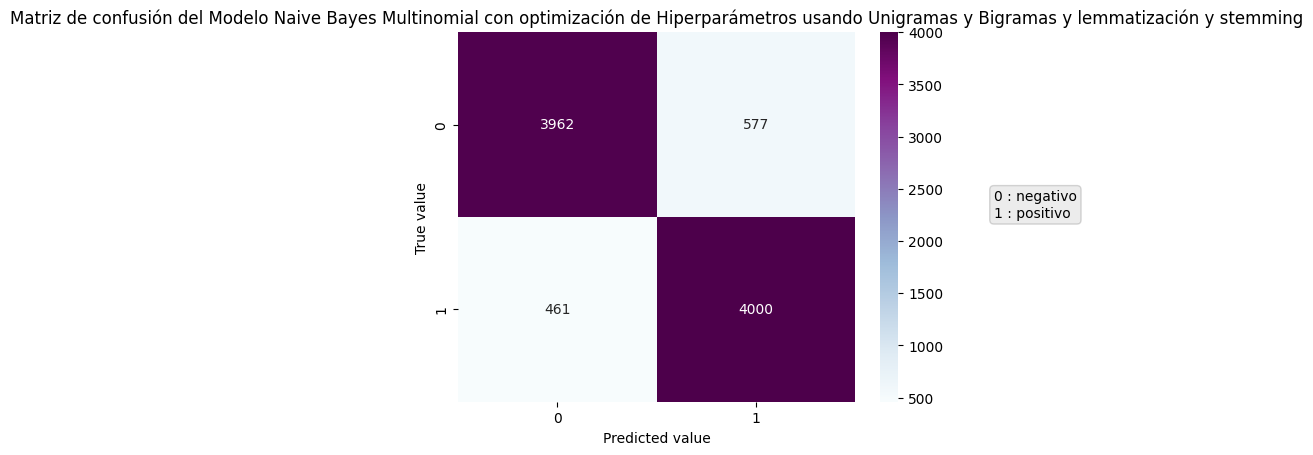

In [76]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo Naive Bayes Multinomial con optimización de Hiperparámetros usando Unigramas y Bigramas y lemmatización y stemming")
plt.text(2.7, 1, f"0 : {labelEncoder.inverse_transform([0])[0]}\n1 : {labelEncoder.inverse_transform([1])[0]}", bbox=dict(boxstyle='round', facecolor='grey', alpha=0.15))
plt.show()

Mostramos las distintas métricas

In [77]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8846666666666667
Recall: 0.8966599417171038
Precision: 0.8739348918505572
f1 score: 0.8851515822084531


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [78]:
y_pred = multinomialNBPipeline.predict(criticsTest["review"])

Agrupamos en el dataframe los valores predichos decodeados con el label encoder

In [79]:
kaggleResult = criticsTest.copy()
kaggleResult.drop(columns=["review"], inplace=True)

kaggleResult["sentimiento"] = labelEncoder.inverse_transform(y_pred)

kaggleResult.head(2)

,ID,sentimiento
0,60000,negativo
1,60001,negativo


Para exportar a Kaggle exportamos el csv. El `runNumber` es sólo un número que ponemos para no pisar los submits

In [80]:
kaggleResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_naive_bayes_multinomial.csv", index=False)

Guardamos una serialización del modelo

In [81]:
filename = f'./naive_bayes_multinomial_model_{runNumber}.joblib'
modelInfo = {'model': multinomialNBPipeline}

joblib.dump(modelInfo, filename)

['./naive_bayes_multinomial_model_13.joblib']